In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics._scorer import _SCORERS
from xgboost import XGBRegressor,XGBClassifier
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
%matplotlib inline

In [2]:
#data prep
trainset = pd.read_csv("data/train.csv")
testset = pd.read_csv("data/test.csv")

In [3]:
trainset.head()

,Year,Month,Day,Hour,Minute,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,Temperature,Pressure,Relative Humidity,Solar Zenith Angle,Precipitable Water,Wind Direction,Wind Speed,Fill Flag
0,2009,1,1,0,0,0,0,0,0,0.0,5.0,1010,75.34,106.15,0.499,346.1,3.1,0
1,2009,1,1,0,30,0,0,0,0,1.0,5.0,1010,80.81,112.28,0.490,346.1,3.1,0
2,2009,1,1,1,0,0,0,0,4,0.0,5.0,1010,78.27,118.50,0.482,347.9,3.2,0
3,2009,1,1,1,30,0,0,0,4,0.0,4.0,1010,78.27,124.78,0.478,347.9,3.1,0
4,2009,1,1,2,0,0,0,0,4,0.0,4.0,1010,76.45,131.12,0.475,350.0,3.0,0


In [4]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175296 entries, 0 to 175295
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Year                175296 non-null  int64  
 1   Month               175296 non-null  int64  
 2   Day                 175296 non-null  int64  
 3   Hour                175296 non-null  int64  
 4   Minute              175296 non-null  int64  
 5   Clearsky DHI        175296 non-null  int64  
 6   Clearsky DNI        175296 non-null  int64  
 7   Clearsky GHI        175296 non-null  int64  
 8   Cloud Type          175296 non-null  int64  
 9   Dew Point           175296 non-null  float64
 10  Temperature         175296 non-null  float64
 11  Pressure            175296 non-null  int64  
 12  Relative Humidity   175296 non-null  float64
 13  Solar Zenith Angle  175296 non-null  float64
 14  Precipitable Water  175296 non-null  float64
 15  Wind Direction      175296 non-nul

In [5]:
testset.head()

,Year,Month,Day,Hour,Minute,Cloud Type,Dew Point,Temperature,Pressure,Relative Humidity,Solar Zenith Angle,Precipitable Water,Wind Direction,Wind Speed,Fill Flag,Clearsky DHI,Clearsky DNI,Clearsky GHI
0,2019,1,1,0,0,7,18.4,18.8,1008,97.70,106.23,3.5,190,2.3,0,NaN,NaN,NaN
1,2019,1,1,0,30,3,18.4,18.6,1008,98.92,112.36,3.5,187,2.5,0,NaN,NaN,NaN
2,2019,1,1,1,0,3,18.2,18.5,1008,98.35,118.58,3.5,184,2.8,0,NaN,NaN,NaN
3,2019,1,1,1,30,3,18.2,18.3,1008,99.58,124.86,3.5,185,3.0,0,NaN,NaN,NaN
4,2019,1,1,2,0,0,18.0,18.0,1008,99.71,131.20,3.6,186,3.1,0,NaN,NaN,NaN


In [6]:
trainset.skew()

Year                  -0.000144
Month                 -0.009526
Day                    0.006912
Hour                   0.000000
Minute                 0.000000
Clearsky DHI           0.925063
Clearsky DNI           0.406380
Clearsky GHI           0.883322
Cloud Type             0.713420
Dew Point             -0.678322
Temperature           -0.355291
Pressure               0.221701
Relative Humidity     -0.765209
Solar Zenith Angle    -0.001963
Precipitable Water     0.111489
Wind Direction        -0.119570
Wind Speed             1.086645
Fill Flag             12.829921
dtype: float64

In [7]:
trainset.describe()

,Year,Month,Day,Hour,Minute,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,Temperature,Pressure,Relative Humidity,Solar Zenith Angle,Precipitable Water,Wind Direction,Wind Speed,Fill Flag
count,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000
mean,2013.500274,6.523549,15.727820,11.500000,15.000000,53.065426,330.065295,254.365490,2.540474,13.564431,18.266769,1003.185230,79.376366,89.729463,2.903732,188.877796,2.262871,0.740433
std,2.871908,3.448543,8.799349,6.922206,15.000043,64.201407,370.030821,327.705006,3.021879,8.196787,8.943096,5.935749,19.678235,40.085451,1.546979,99.014733,1.281902,6.575655
min,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-17.000000,-9.000000,970.000000,7.190000,8.550000,0.122000,0.000000,0.000000,0.000000
25%,2011.000000,4.000000,8.000000,5.750000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,12.000000,1000.000000,65.590000,56.450000,1.534000,97.400000,1.300000,0.000000
50%,2013.500000,7.000000,16.000000,11.500000,15.000000,0.000000,0.000000,0.000000,1.000000,15.000000,20.000000,1000.000000,84.230000,89.860000,2.866000,200.000000,2.000000,0.000000
75%,2016.000000,10.000000,23.000000,17.250000,30.000000,103.000000,736.000000,535.000000,6.000000,21.000000,25.000000,1010.000000,97.950000,123.060000,4.223000,272.000000,3.000000,0.000000
max,2018.000000,12.000000,31.000000,23.000000,30.000000,565.000000,1040.000000,1063.000000,10.000000,26.900000,40.000000,1024.000000,100.000000,171.550000,7.700000,360.000000,12.900000,100.000000


<Axes: >

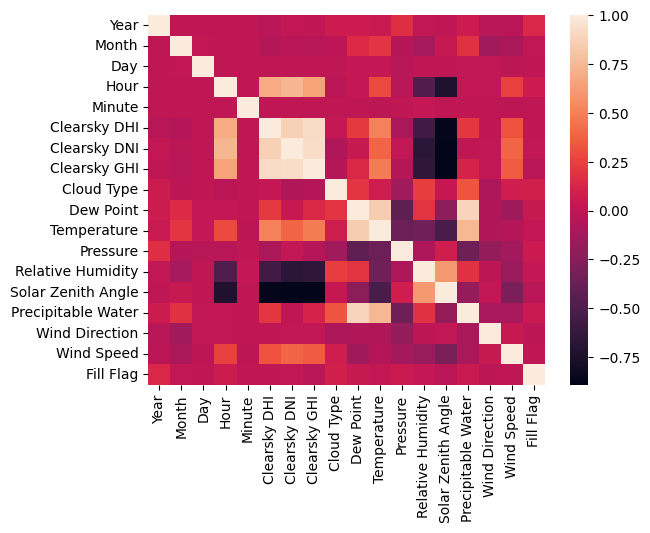

In [8]:
corr_mat = trainset.corr()
sns.heatmap(corr_mat)

<Axes: >

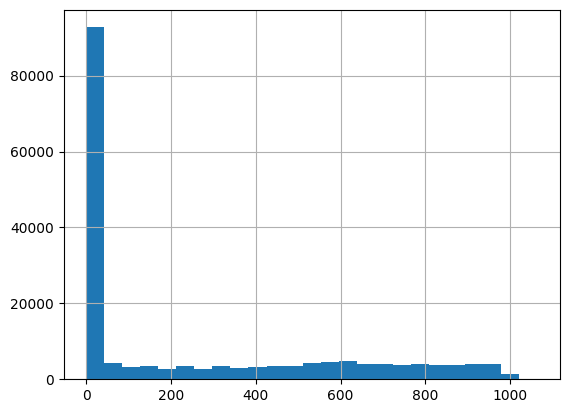

In [9]:
trainset['Clearsky GHI'].hist(bins=25)

<Axes: >

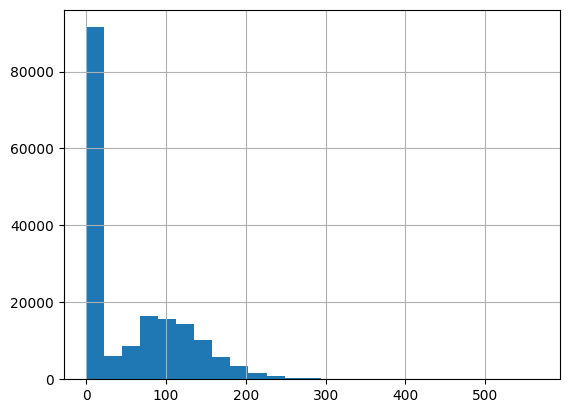

In [10]:
trainset['Clearsky DHI'].hist(bins=25)

<Axes: >

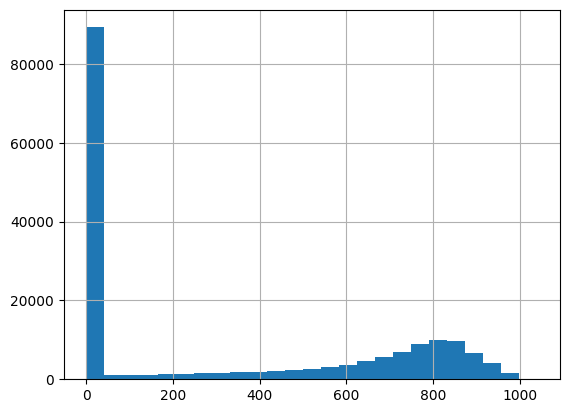

In [11]:
trainset['Clearsky DNI'].hist(bins=25)

<Axes: >

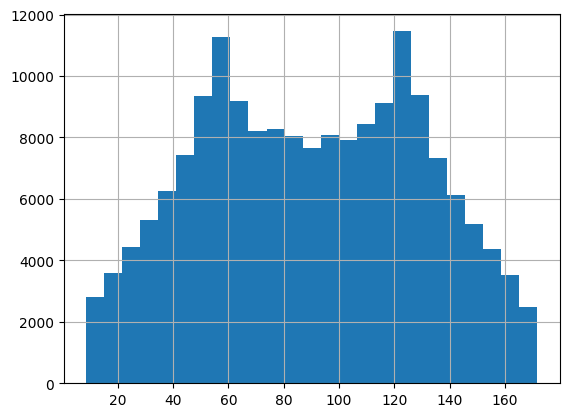

In [12]:
trainset['Solar Zenith Angle'].hist(bins=25)

<Axes: >

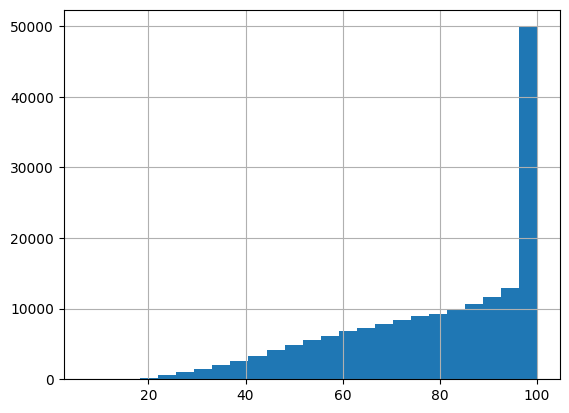

In [13]:
trainset['Relative Humidity'].hist(bins=25)

<Axes: >

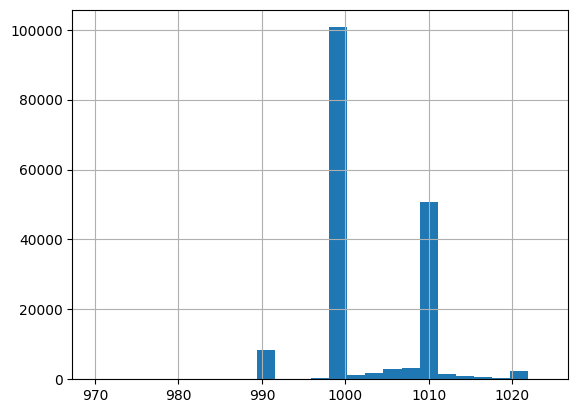

In [14]:
trainset['Pressure'].hist(bins=25)

<Axes: xlabel='Clearsky GHI', ylabel='Density'>

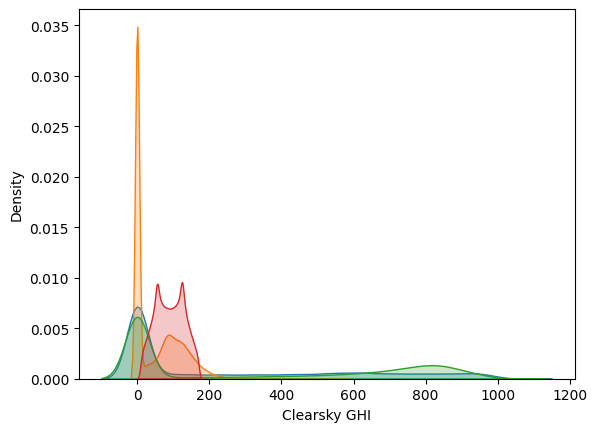

In [15]:
sns.kdeplot(data = trainset['Clearsky GHI'], fill = True, label="GHI")
sns.kdeplot(data = trainset['Clearsky DHI'], fill = True, label="GHI")
sns.kdeplot(data = trainset['Clearsky DNI'], fill = True, label="DNI")
sns.kdeplot(data = trainset['Solar Zenith Angle'], fill = True, label="GHI")

<Axes: xlabel='Relative Humidity', ylabel='Density'>

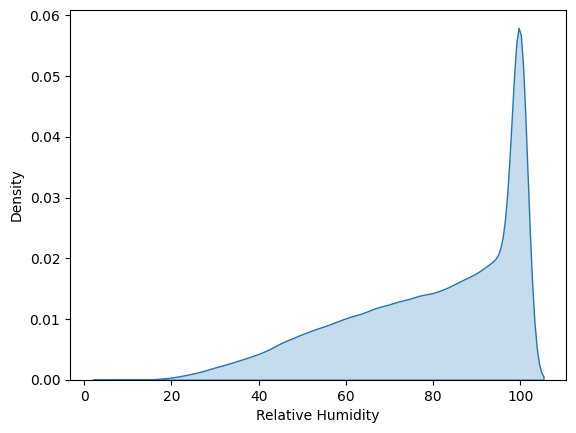

In [16]:
sns.kdeplot(data = trainset['Relative Humidity'], fill = True, label="GHI")

<Axes: >

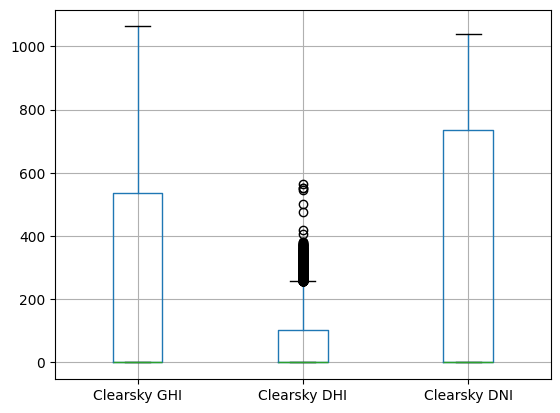

In [17]:
trainset.boxplot(column = ['Clearsky GHI','Clearsky DHI','Clearsky DNI',])

<Axes: >

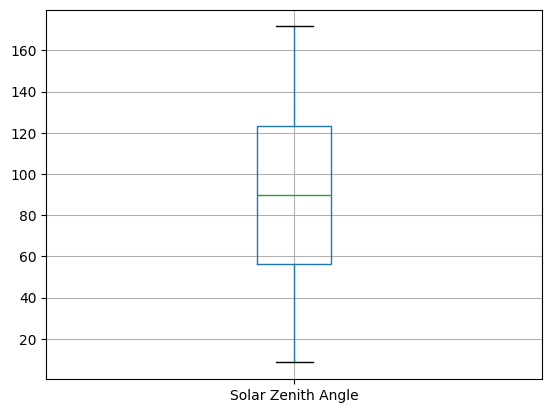

In [18]:
trainset.boxplot(column = ['Solar Zenith Angle'])